In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install TurkishStemmer via pip
!pip install TurkishStemmer

# Clone and install NVIDIA Apex for optimized training (requires CUDA)
!git clone https://github.com/NVIDIA/apex.git
%cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd ..

# Install SimpleTransformers and other dependencies
!pip install simpletransformers
!pip install torch torchvision torchaudio
!pip install tensorflow keras
!pip install scikit-learn
!pip install xgboost lightgbm
!pip install transformers
!pip install torch



fatal: destination path 'apex' already exists and is not an empty directory.
/content/apex
Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
DEPRECATION: --build-option and --global-option are deprecated. pip 24.2 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11859
Processing /content/apex
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-tmgwtw4d
  Entered build tracker: /tmp/pip-build-tracker-tmgwtw4d
  Created temporary directory: /tmp/pip-install-m17nvggy
  Created temporary directory: /tmp/pip-ephem-wheel-cache-9x7f75ar
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.o

In [ ]:
import re
import os
import shutil
import nltk
import pandas as pd
import numpy as np
from TurkishStemmer import TurkishStemmer
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer

# Metin Özellik Çıkarımı
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model Eğitimi ve Değerlendirme
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    log_loss,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import gensim as GN

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import label_binarize

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch


In [ ]:
# NLTK ve Türkçe İşlemler
nltk_data_dir = './nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
nltk.data.path.append(nltk_data_dir)

# WordNet kontrol
wordnet_path = os.path.join(nltk_data_dir, 'corpora', 'wordnet')
if os.path.exists(wordnet_path):
    print("WordNet is correctly downloaded.")
else:
    print("WordNet download failed. Please check the download steps.")

# --- Veri Yükleme ---
dataset_path = '/content/drive/MyDrive/7allV03.csv'
df = pd.read_csv(dataset_path)
print("Dataset Loaded Successfully.")
print(df.head())

# Eksik değer kontrolü ve silinmesi
print("\nMissing Values in Each Column:")
print(df.isnull().sum())
df = df.dropna()
print("\nDataset shape after dropping missing values:", df.shape)

# --- Metin ön işleme ---
WPT = WordPunctTokenizer()
stemmer = TurkishStemmer()
stop_word_list = stopwords.words('turkish')
pattern = r"[{}]".format(",.;:")

docs_list = []
print("\nStarting Text Preprocessing...")

for index, doc in enumerate(df['text']):
    doc = re.sub(r"\d+", " ", doc)       # sayıları sil
    doc = re.sub(pattern, "", doc)       # noktalama sil
    doc = doc.lower()                    # küçük harfe çevir
    tokens = WPT.tokenize(doc)          # tokenize et
    filtered_tokens = [item for item in tokens if item not in stop_word_list]  # stopword çıkar
    stemmed_words = [stemmer.stem(word) for word in filtered_tokens]           # stem
    cleaned_doc = " ".join(stemmed_words)
    docs_list.append(cleaned_doc)

    if (index + 1) % 1000 == 0:
        print(f"Processed {index + 1} documents")

print("Text Preprocessing Completed.")


[nltk_data] Downloading package wordnet to ./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


WordNet download failed. Please check the download steps.
Dataset Loaded Successfully.
   category                                               text
0  siyaset    3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1  siyaset    mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2  siyaset    disko lar kaldırılıyor başbakan_yardımcısı ar...
3  siyaset    sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4  siyaset    erdoğan idamın bir haklılık sebebi var demek ...

Missing Values in Each Column:
category    0
text        0
dtype: int64

Dataset shape after dropping missing values: (4900, 2)

Starting Text Preprocessing...
Processed 1000 documents
Processed 2000 documents
Processed 3000 documents
Processed 4000 documents
Text Preprocessing Completed.


In [ ]:

# --- Özellik Çıkarımı (BoW, TF-IDF, Word2Vec) ---

print("\nStarting Feature Extraction...")

print("\nBag of Words Feature Extraction...")
count_vectorize = CountVectorizer(max_features=5000)
bow_matrix = count_vectorize.fit_transform(docs_list).toarray()
print(f"BoW matrix shape: {bow_matrix.shape}")

print("\nTF-IDF Feature Extraction...")
tfidf_vector = TfidfVectorizer(max_features=5000, use_idf=True)
tfidf_matrix = tfidf_vector.fit_transform(docs_list).toarray()
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

print("\nWord2Vec Feature Extraction...")
tokenized_docs = [doc.split() for doc in docs_list]
word2vec_model = GN.models.Word2Vec(
    sentences=tokenized_docs,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)
print("Word2Vec model trained.")

def get_word2vec_features(model, tokenized_docs):
    features = []
    for tokens in tokenized_docs:
        if len(tokens) == 0:
            features.append(np.zeros(model.vector_size))
            continue
        word_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if word_vectors:
            features.append(np.mean(word_vectors, axis=0))
        else:
            features.append(np.zeros(model.vector_size))
    return np.array(features)

word2vec_features = get_word2vec_features(word2vec_model, tokenized_docs)
print(f"Word2Vec feature matrix shape: {word2vec_features.shape}")

print("Feature Extraction Completed.")

# --- Label Encoding ---
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes} -> {label_encoder.classes_}")

# Model performanslarını saklayacağımız sözlük
model_performance = {}


Starting Feature Extraction...

Bag of Words Feature Extraction...
BoW matrix shape: (4900, 5000)

TF-IDF Feature Extraction...
TF-IDF matrix shape: (4900, 5000)

Word2Vec Feature Extraction...
Word2Vec model trained.
Word2Vec feature matrix shape: (4900, 100)
Feature Extraction Completed.
Number of classes: 7 -> ['dunya ' 'ekonomi ' 'kultur ' 'saglik ' 'siyaset ' 'spor ' 'teknoloji ']


In [ ]:
def plot_roc_curves(y_test_binarized, y_pred, label_encoder, model_name):
    num_classes = len(label_encoder.classes_)
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()

    for i in range(num_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    plt.figure()
    for i in range(num_classes):
        class_label = label_encoder.classes_[i]
        plt.plot(fpr_dict[i], tpr_dict[i], label=f"{class_label} (AUC={roc_auc_dict[i]:.3f})")

    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

In [ ]:

def plot_confusion_matrix(y_test, y_pred_classes, label_encoder,model_name,figsize=(10,8)):
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='YlGnBu',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [ ]:


def train_and_evaluate_model(
    model,
    X,
    y,
    label_encoder,
    test_size=0.1,
    model_name=None,
    random_state=42,

):
    # Eğitim & Test seti ayırma
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Modeli eğit
    model.fit(X_train, y_train)

    # Tahminler
    y_pred = model.predict(X_test)

    # predict_proba varsa olasılık tahminleri
    try:
        y_probs = model.predict_proba(X_test)
    except AttributeError:
        y_probs = None

    # Metrikler hesaplama
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )

    if y_probs is not None:
        n_classes = len(np.unique(y_test))
        # Çok sınıflı ROC AUC hesaplama
        y_test_binarized = label_binarize(y_test, classes=range(n_classes))
        roc_auc = roc_auc_score(y_test_binarized, y_probs, multi_class='ovr')
        loss_val = log_loss(y_test_binarized, y_probs)
    else:
        roc_auc = np.nan
        loss_val = np.nan

    print(f"\nModel: {model.__class__.__name__}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC AUC  : {roc_auc:.4f}")
    else:
        print("ROC AUC  : N/A (no predict_proba)")
    if not np.isnan(loss_val):
        print(f"Log Loss : {loss_val:.4f}")
    else:
        print("Log Loss : N/A (no predict_proba)")

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder,model_name=model_name)
    # ROC Eğrileri Hesaplama ve Çizimi (Tüm sınıflar için)

    # ROC Eğrileri Çizimi (Multi-class)
    if y_probs is not None:
        plot_roc_curves(y_test_binarized, y_probs, label_encoder,model_name=model_name)

    result_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC_AUC": roc_auc,
        "Log_Loss": loss_val
    }

    return result_dict

Random Forest


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)



Model: RandomForestClassifier
Accuracy : 0.8857
Precision: 0.8884
Recall   : 0.8857
F1-Score : 0.8847
ROC AUC  : 0.9876
Log Loss : 0.5682


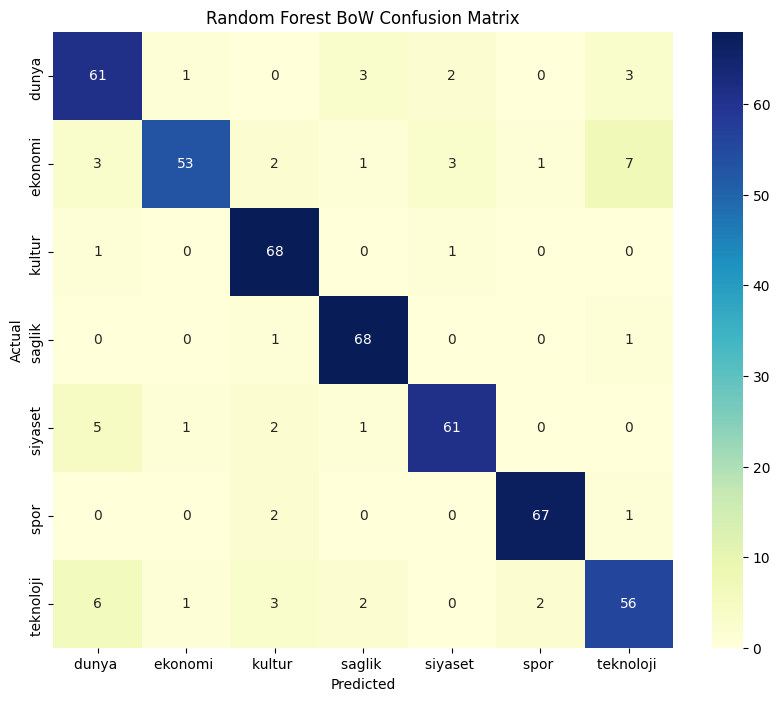

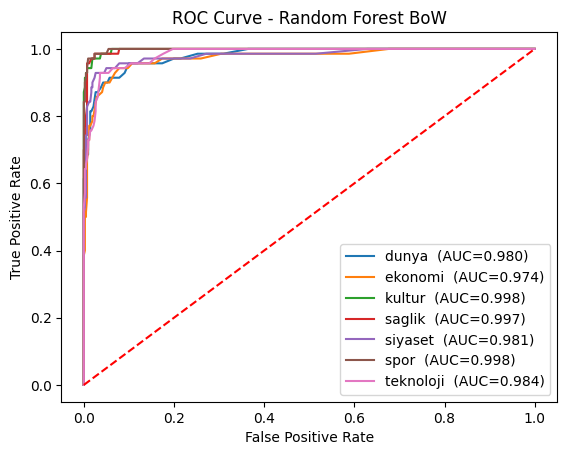

In [ ]:
X = bow_matrix
results_rf_bow  = train_and_evaluate_model(rf_model,  X, y, label_encoder,model_name="Random Forest BoW")


Model: RandomForestClassifier
Accuracy : 0.9061
Precision: 0.9067
Recall   : 0.9061
F1-Score : 0.9054
ROC AUC  : 0.9893
Log Loss : 0.5656


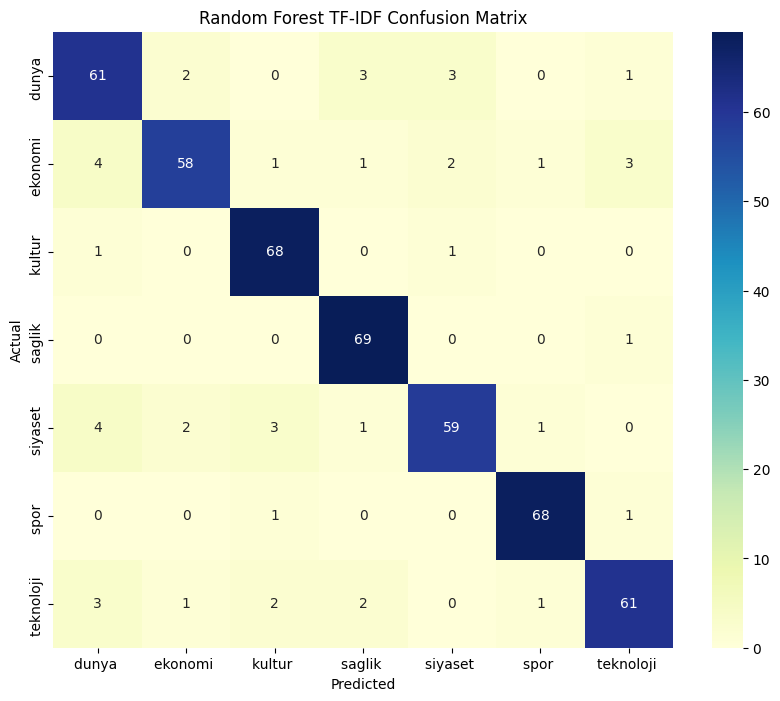

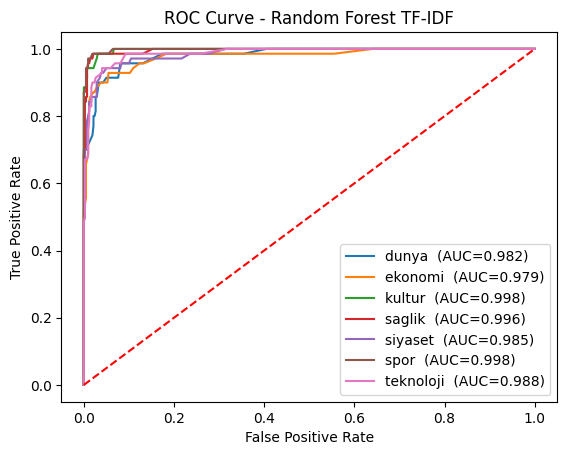

In [ ]:
X = tfidf_matrix
results_rf_tfidf  = train_and_evaluate_model(rf_model,  X, y, label_encoder,model_name="Random Forest TF-IDF")



Model: RandomForestClassifier
Accuracy : 0.8347
Precision: 0.8389
Recall   : 0.8347
F1-Score : 0.8343
ROC AUC  : 0.9778
Log Loss : 0.5782


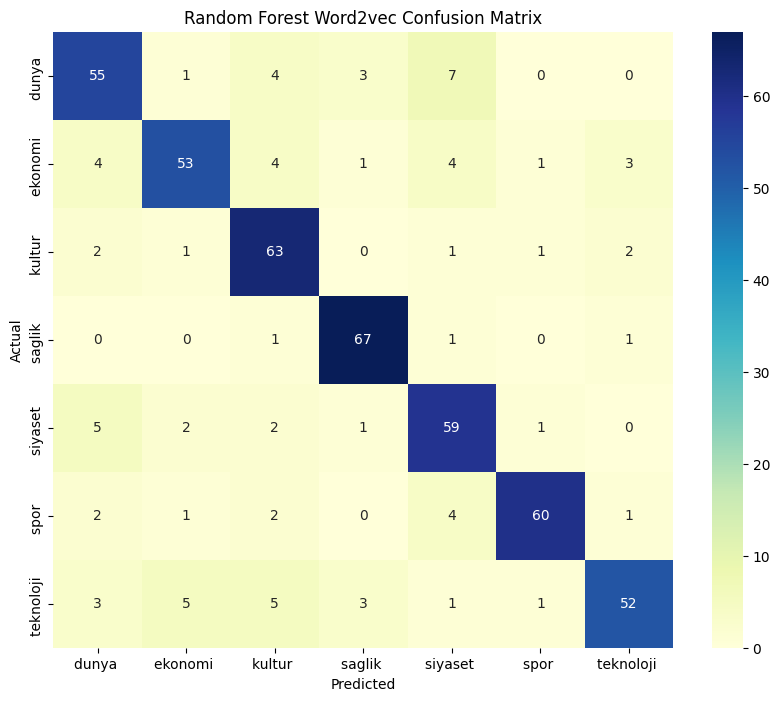

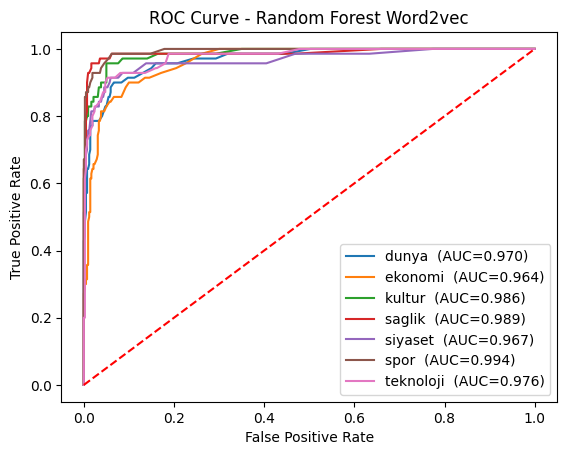

In [ ]:
X = word2vec_features
results_rf_word2vec  = train_and_evaluate_model(rf_model,  X, y, label_encoder,model_name="Random Forest Word2vec")

Xgboost

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:11:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBClassifier
Accuracy : 0.9000
Precision: 0.9007
Recall   : 0.9000
F1-Score : 0.8986
ROC AUC  : 0.9912
Log Loss : 0.2826


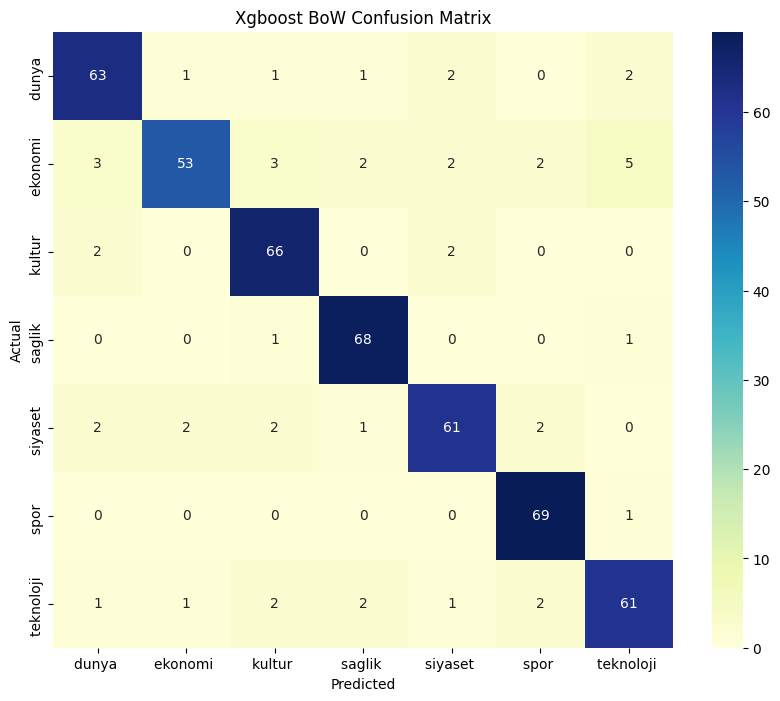

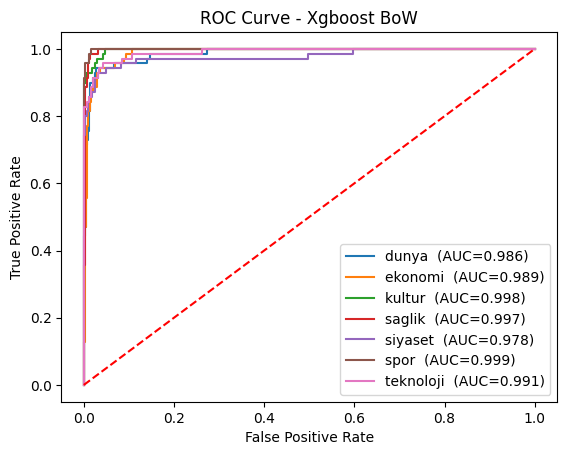

In [ ]:
X = bow_matrix
results_xgb_bow = train_and_evaluate_model(xgb_model, X, y, label_encoder,model_name="Xgboost BoW")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:12:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBClassifier
Accuracy : 0.9061
Precision: 0.9056
Recall   : 0.9061
F1-Score : 0.9045
ROC AUC  : 0.9905
Log Loss : 0.2966


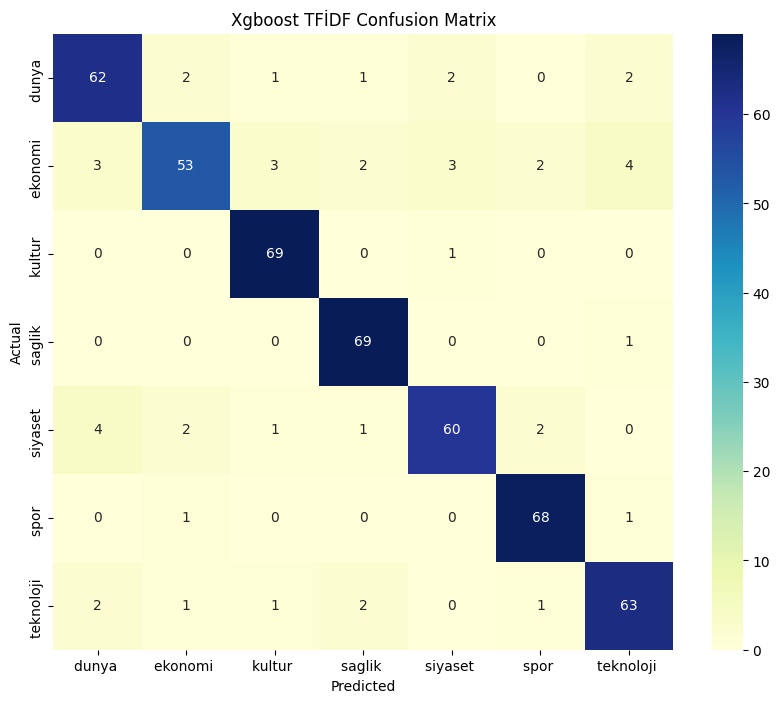

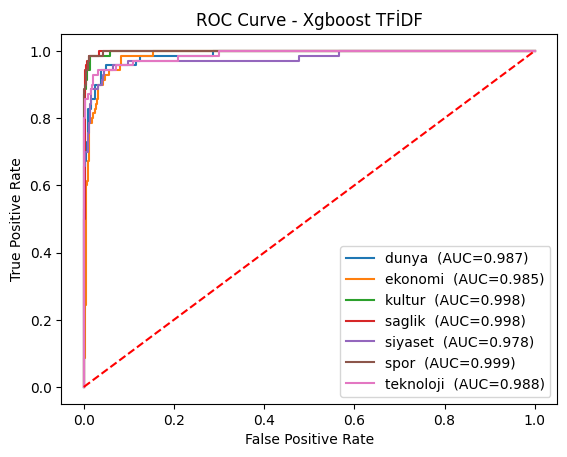

In [ ]:
X = tfidf_matrix
results_xgb_tfidf = train_and_evaluate_model(xgb_model, X, y, label_encoder,model_name="Xgboost TFİDF")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBClassifier
Accuracy : 0.8571
Precision: 0.8608
Recall   : 0.8571
F1-Score : 0.8573
ROC AUC  : 0.9822
Log Loss : 0.4959


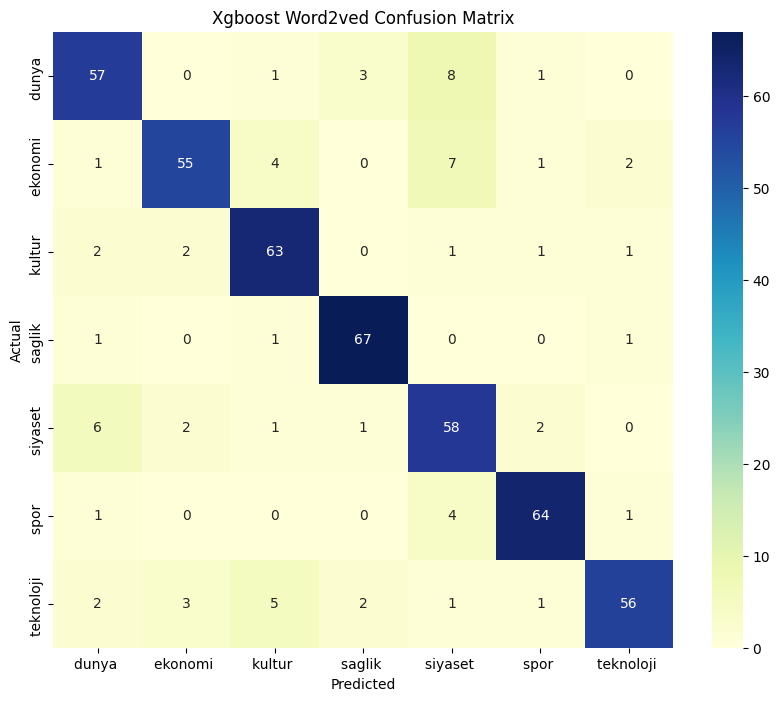

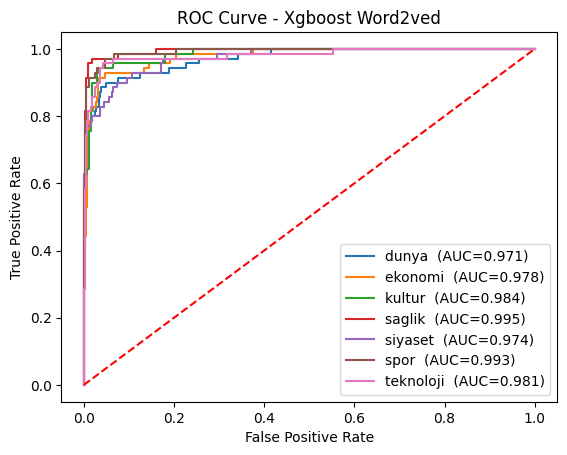

In [ ]:
X=word2vec_features
results_xgb_word2vec = train_and_evaluate_model(xgb_model, X, y, label_encoder,model_name="Xgboost Word2ved")

lightgbm

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21506
[LightGBM] [Info] Number of data points in the train set: 4410, number of used features: 4250
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Model: LGBMClassifier
Accuracy : 0.9286
Precision: 0.9280
Recall   : 0.9286
F1-Score : 0.9278
ROC AUC  : 0.9924
Log Loss : 0.2803


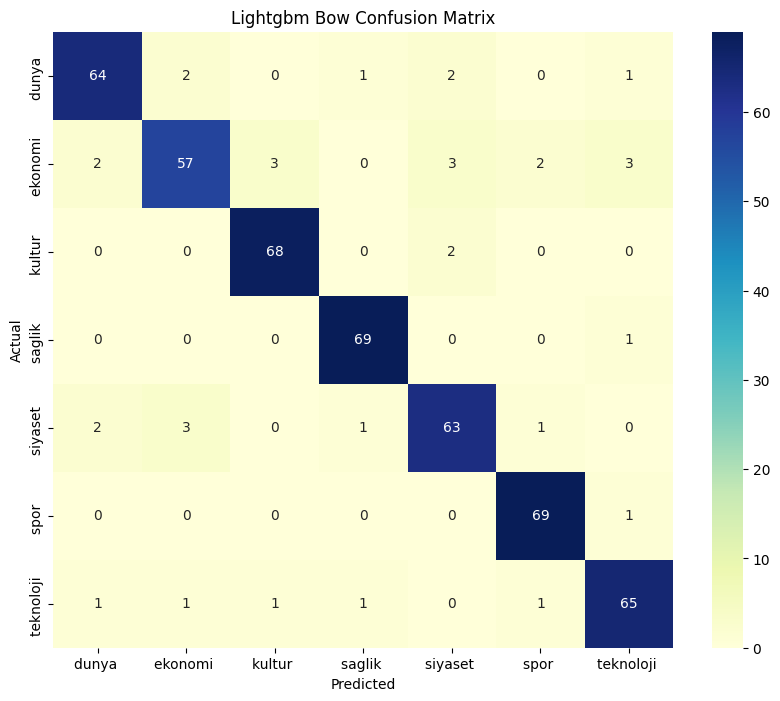

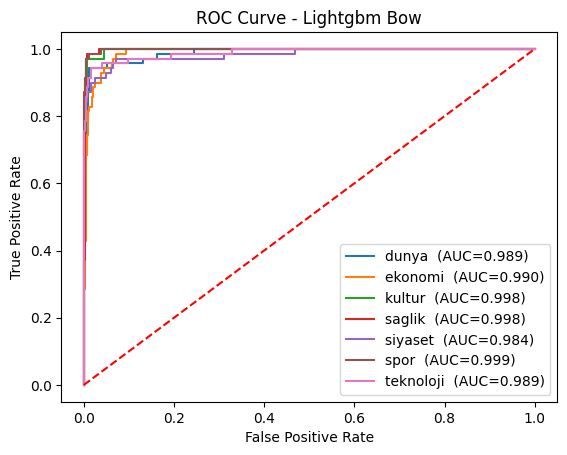

In [ ]:
X = bow_matrix
results_lgb_bow = train_and_evaluate_model(lgb_model, X, y, label_encoder,model_name="Lightgbm Bow")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152813
[LightGBM] [Info] Number of data points in the train set: 4410, number of used features: 4250
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Model: LGBMClassifier
Accuracy : 0.9224
Precision: 0.9219
Recall   : 0.9224
F1-Score : 0.9218
ROC AUC  : 0.9925
Log Loss : 0.2833


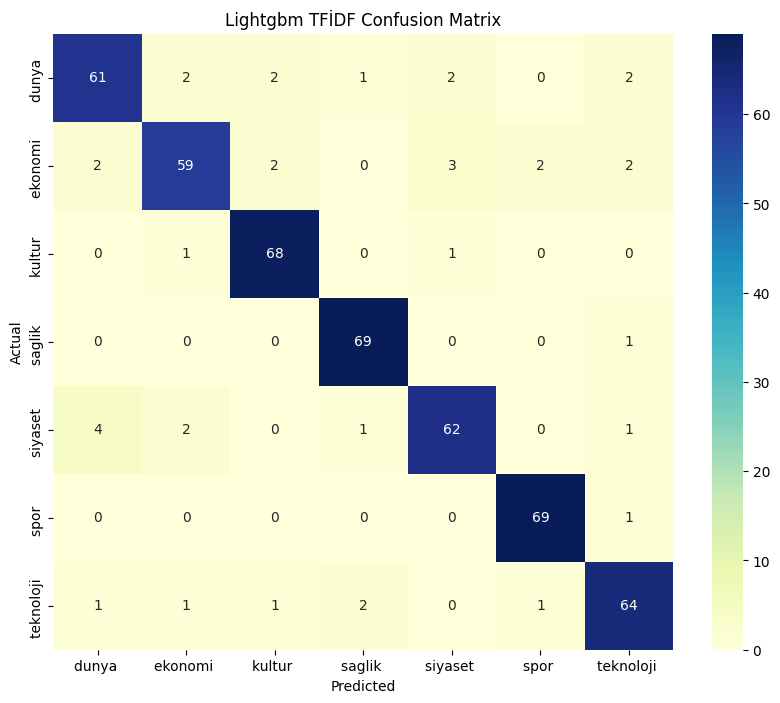

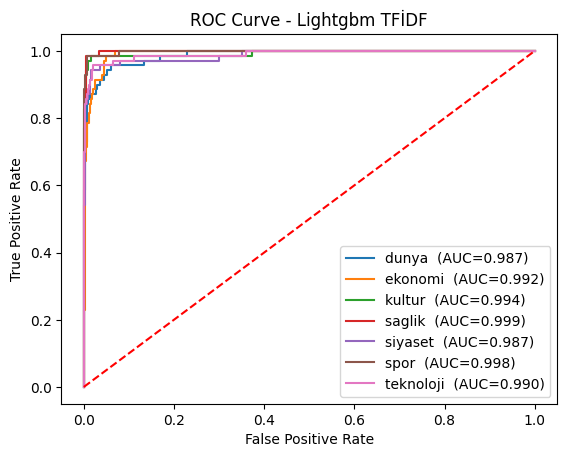

In [ ]:
X = tfidf_matrix
results_lgb_tfidf = train_and_evaluate_model(lgb_model, X, y, label_encoder,model_name="Lightgbm TFİDF")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 4410, number of used features: 100
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Model: LGBMClassifier
Accuracy : 0.8531
Precision: 0.8568
Recall   : 0.8531
F1-Score : 0.8536
ROC AUC  : 0.9831
Log Loss : 0.5379


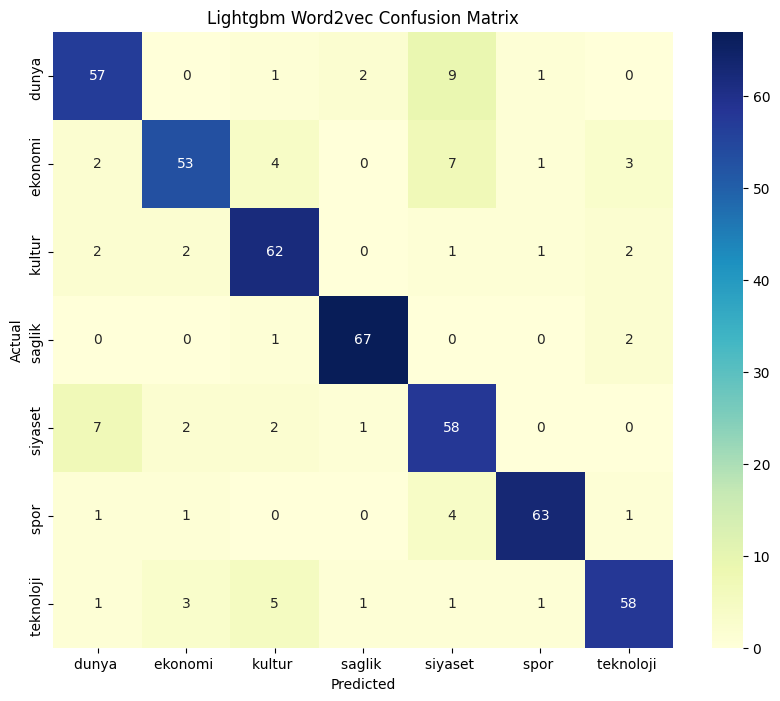

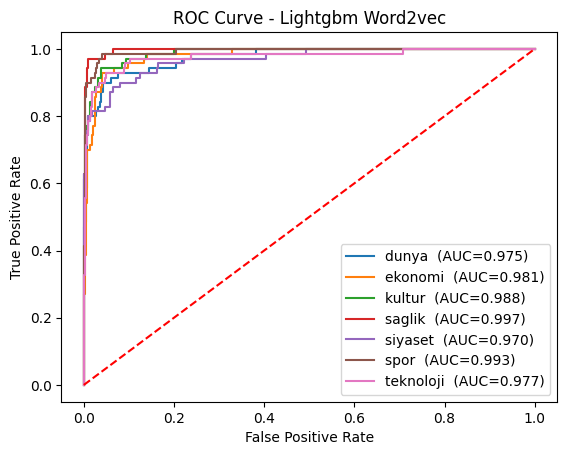

In [ ]:
X = word2vec_features
results_lgb_word2vec = train_and_evaluate_model(lgb_model, X, y, label_encoder,model_name="Lightgbm Word2vec")

SVM

In [ ]:
svm_model = SVC(probability=True, random_state=42)  # ROC AUC ve log_loss için probability=True


Model: SVC
Accuracy : 0.8857
Precision: 0.8870
Recall   : 0.8857
F1-Score : 0.8855
ROC AUC  : 0.9830
Log Loss : 0.4029


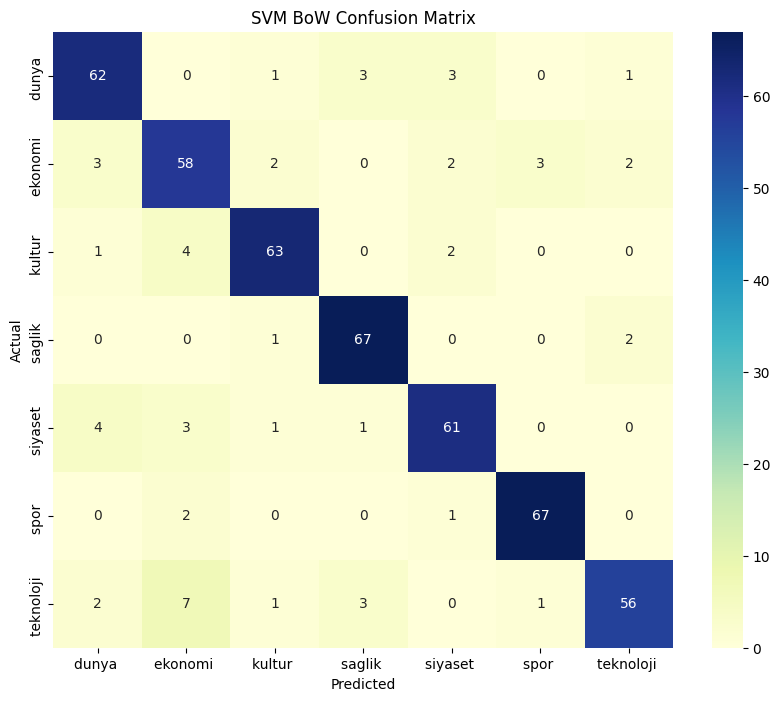

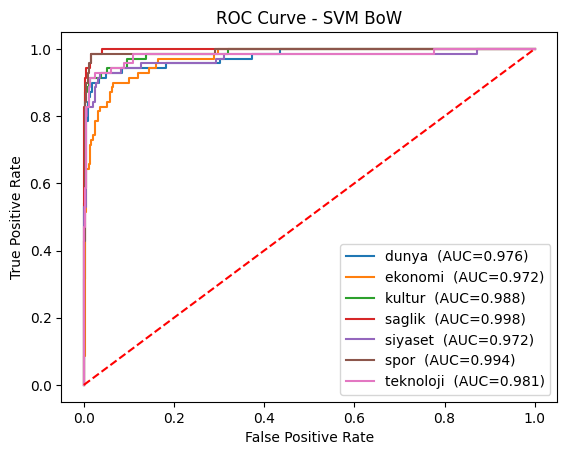

In [ ]:
X = bow_matrix
results_svm_bow = train_and_evaluate_model(svm_model, X, y, label_encoder,model_name="SVM BoW")


Model: SVC
Accuracy : 0.9265
Precision: 0.9268
Recall   : 0.9265
F1-Score : 0.9264
ROC AUC  : 0.9877
Log Loss : 0.3044


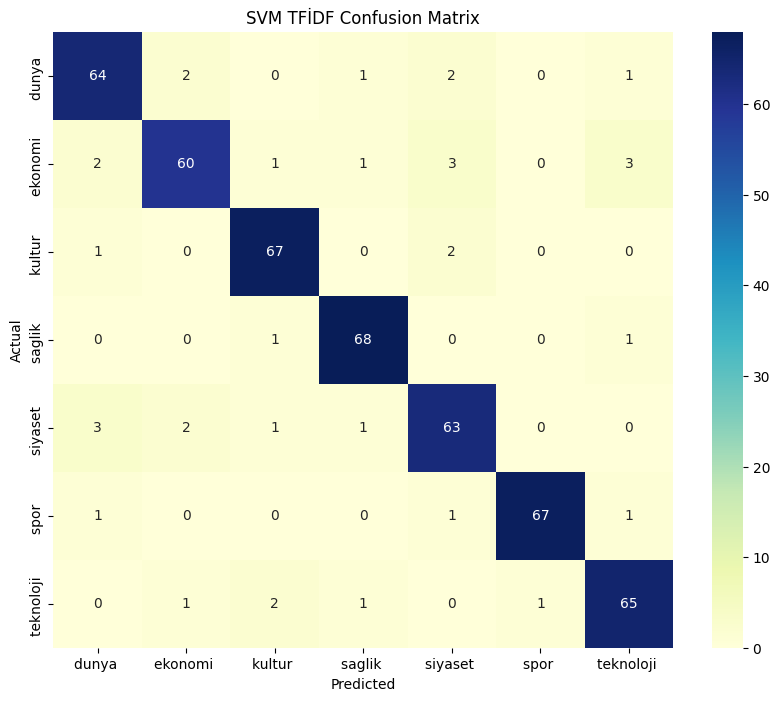

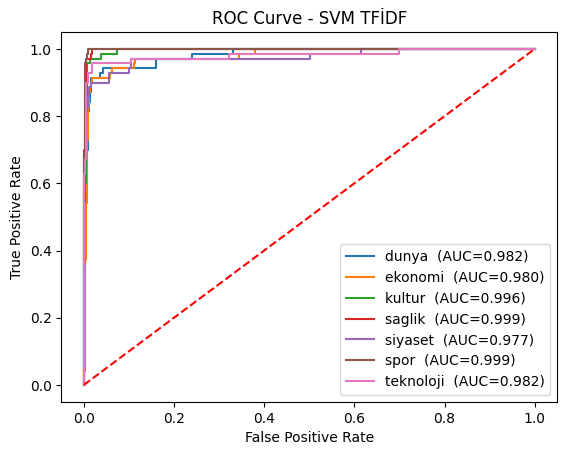

In [ ]:
X = tfidf_matrix
results_svm_tfidf = train_and_evaluate_model(svm_model, X, y, label_encoder,model_name="SVM TFİDF")


Model: SVC
Accuracy : 0.8449
Precision: 0.8464
Recall   : 0.8449
F1-Score : 0.8446
ROC AUC  : 0.9805
Log Loss : 0.4519


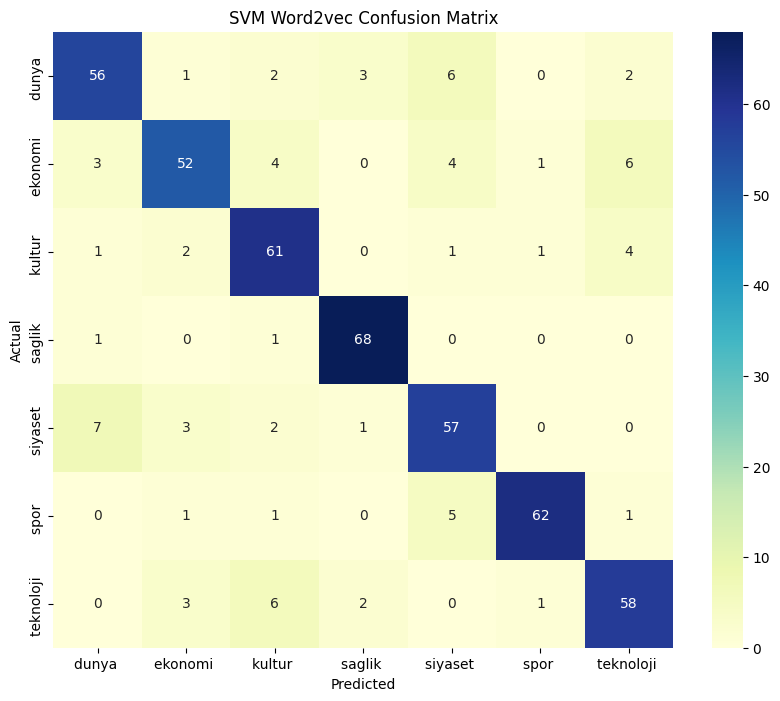

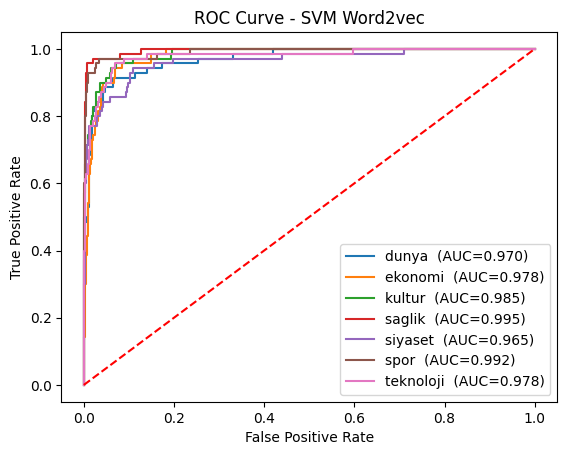

In [ ]:
X = word2vec_features
results_svm_word2vec = train_and_evaluate_model(svm_model, X, y, label_encoder,model_name="SVM Word2vec")

In [ ]:

# Birleştireceğimiz verileri (result_dict, feature_name) çiftleriyle bir listeye koyuyoruz.
rf_results_list = [
    (results_rf_word2vec, "RF + Word2Vec"),
    (results_rf_tfidf,    "RF + TF-IDF"),
    (results_rf_bow,      "RF + BoW"),
    (results_xgb_bow, "XGBoost + BoW"),
    (results_xgb_tfidf, "XGBoost + TF-IDF"),
    (results_xgb_word2vec, "XGBoost + Word2Vec"),
    (results_lgb_bow, "LightGBM + BoW"),
    (results_lgb_tfidf, "LightGBM + TF-IDF"),
    (results_lgb_word2vec, "LightGBM + Word2Vec"),
    (results_svm_bow, "SVM + BoW"),
    (results_svm_tfidf, "SVM + TF-IDF"),
    (results_svm_word2vec, "SVM + Word2Vec")
]

# Geniş form veri saklayacağımız liste
df_wide_list = []

# Her sonuç sözlüğünü tek satır olacak şekilde dönüştür
for metrics_dict, combo_name in rf_results_list:
    # Yeni bir satır sözlüğü oluştur
    row_dict = {
        "Model+Feature": combo_name
    }
    # Metrikleri bu satıra ekle
    row_dict.update(metrics_dict)
    # Listeye ekle
    df_wide_list.append(row_dict)

# Listeyi DataFrame'e dönüştür
df_results_wide = pd.DataFrame(df_wide_list)

# Sonuçları görüntüleme
df_results_wide

,Model+Feature,Accuracy,Precision,Recall,F1-Score,ROC_AUC,Log_Loss
0,RF + Word2Vec,0.834694,0.838874,0.834694,0.834308,0.977750,0.578204
1,RF + TF-IDF,0.906122,0.906671,0.906122,0.905370,0.989332,0.565562
2,RF + BoW,0.885714,0.888377,0.885714,0.884712,0.987612,0.568242
3,XGBoost + BoW,0.900000,0.900651,0.900000,0.898609,0.991210,0.282583
4,XGBoost + TF-IDF,0.906122,0.905638,0.906122,0.904515,0.990496,0.296602
5,XGBoost + Word2Vec,0.857143,0.860812,0.857143,0.857346,0.982221,0.495904
6,LightGBM + BoW,0.928571,0.927968,0.928571,0.927801,0.992405,0.280274
7,LightGBM + TF-IDF,0.922449,0.921853,0.922449,0.921771,0.992488,0.283292
8,LightGBM + Word2Vec,0.853061,0.856793,0.853061,0.853565,0.983081,0.537868
9,SVM + BoW,0.885714,0.887014,0.885714,0.885549,0.982964,0.402943


In [ ]:
def build_and_train_ann(X, y, num_classes, model_key,model_name):

    print(f"\n--- ANN Training with {model_key} Features ---")

    # Veriyi eğitim ve test olarak ayırma
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    # Özellikleri ölçeklendirme
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Label'ları one-hot encode etme
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # ANN modelini tanımlama
    ann_model = Sequential()
    ann_model.add(Dense(512, input_dim=X_train_scaled.shape[1], activation='relu'))
    ann_model.add(Dropout(0.5))
    ann_model.add(Dense(256, activation='relu'))
    ann_model.add(Dropout(0.5))
    ann_model.add(Dense(num_classes, activation='softmax'))

    # Modeli derleme
    ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Erken durdurma (EarlyStopping) tanımlama
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Modeli eğitme
    history = ann_model.fit(
        X_train_scaled, y_train_cat,
        epochs=20,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )

    # Modeli değerlendirme
    loss, accuracy = ann_model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    print(f"Accuracy: {accuracy:.4f}")

    # Tahminler
    y_pred_probs = ann_model.predict(X_test_scaled)        # Sınıf olasılıkları
    y_pred_classes = np.argmax(y_pred_probs, axis=1)       # Sınıf etiketleri

    # Precision, Recall, F1-Score hesaplama
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_classes, average='weighted'
    )

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix çizimi
    plot_confusion_matrix(y_test, y_pred_classes, label_encoder,model_name=model_name)

    # ROC AUC Score hesaplama (One-vs-Rest)
    y_test_binarized = label_binarize(y_test, classes=range(num_classes))
    roc_auc = roc_auc_score(y_test_binarized, y_pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc_auc:.4f}")

    # Log Loss hesaplama
    logloss = log_loss(y_test_binarized, y_pred_probs)
    print(f"Log Loss: {logloss:.4f}")

    # ROC Eğrileri Hesaplama ve Çizimi (Tüm sınıflar için)
    plot_roc_curves(y_test_binarized, y_pred_probs, label_encoder,model_name=model_name)

    # Performansı saklama
    model_performance[f'ANN_{model_key}'] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Log Loss': logloss
    }



--- ANN Training with BoW Features ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3775 - loss: 2.1109 - val_accuracy: 0.8458 - val_loss: 0.6079
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8711 - loss: 0.4228 - val_accuracy: 0.8617 - val_loss: 0.5671
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9448 - loss: 0.1988 - val_accuracy: 0.8753 - val_loss: 0.6198
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9690 - loss: 0.1098 - val_accuracy: 0.8662 - val_loss: 0.7237
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.0735 - val_accuracy: 0.8707 - val_loss: 0.7825
Accuracy: 0.8898
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Precision: 0.8946
Recall: 0.8898
F1-Score: 0.8905


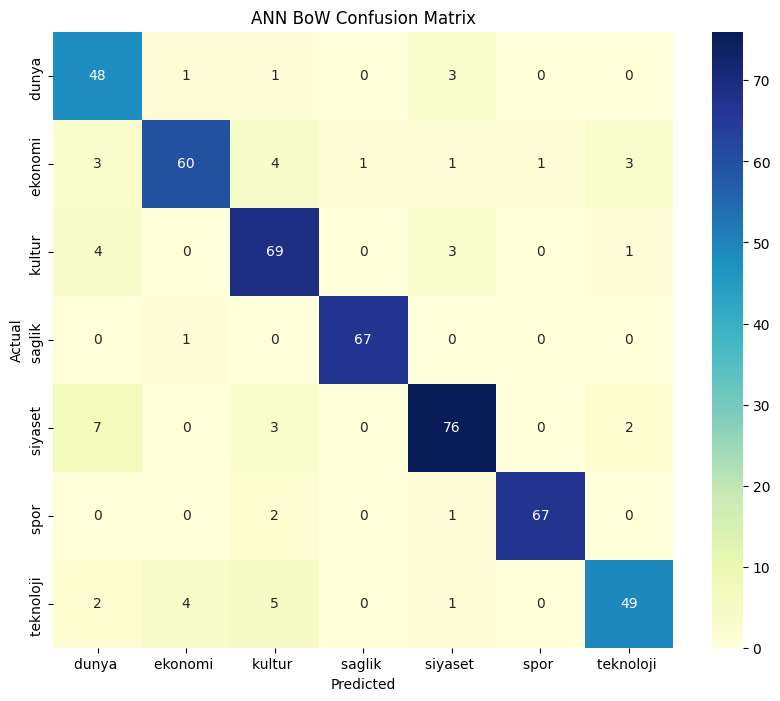

ROC AUC: 0.9902
Log Loss: 0.3259


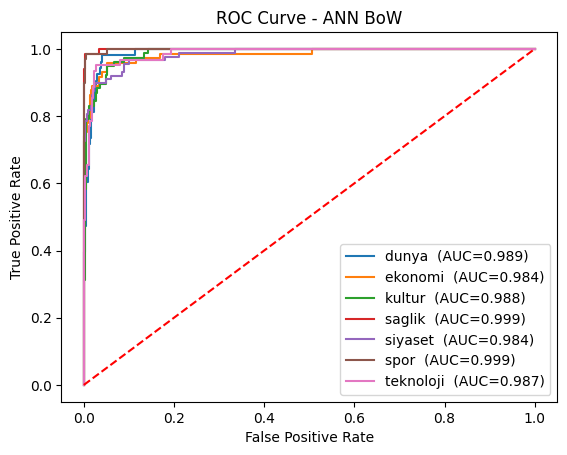

In [ ]:
# ============================
# BoW ile ANN
# ============================
build_and_train_ann(
    X=bow_matrix,
    y=y,
    num_classes=num_classes,
    model_key="BoW",
    model_name="ANN BoW"
)




--- ANN Training with TFIDF Features ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.3818 - loss: 2.0926 - val_accuracy: 0.8435 - val_loss: 0.4899
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8897 - loss: 0.3363 - val_accuracy: 0.8639 - val_loss: 0.4599
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9537 - loss: 0.1295 - val_accuracy: 0.8730 - val_loss: 0.4985
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 0.0844 - val_accuracy: 0.8730 - val_loss: 0.5781
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0539 - val_accuracy: 0.8866 - val_loss: 0.5881
Accuracy: 0.9082
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Precision: 0.9087
Recall: 0.9082
F1-Score: 0.9080


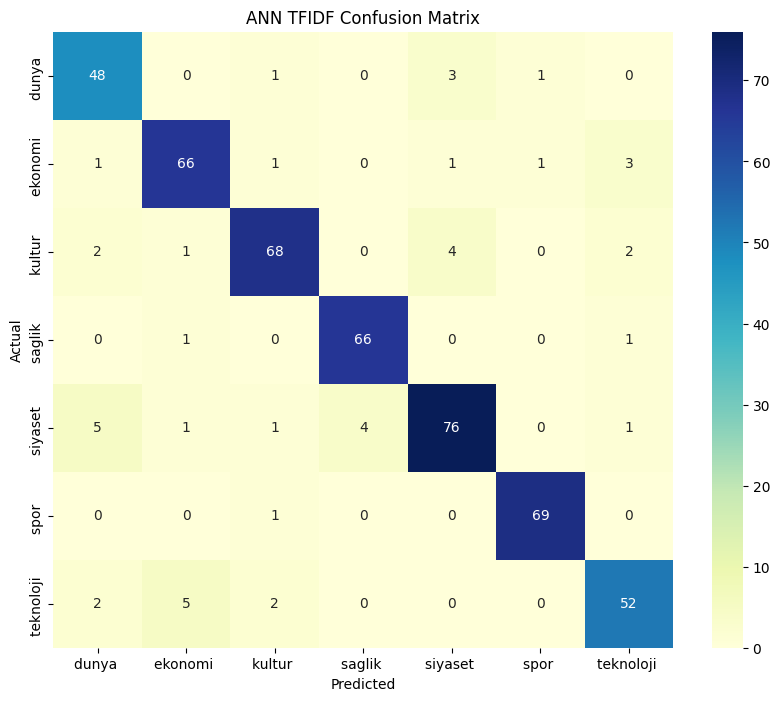

ROC AUC: 0.9912
Log Loss: 0.3025


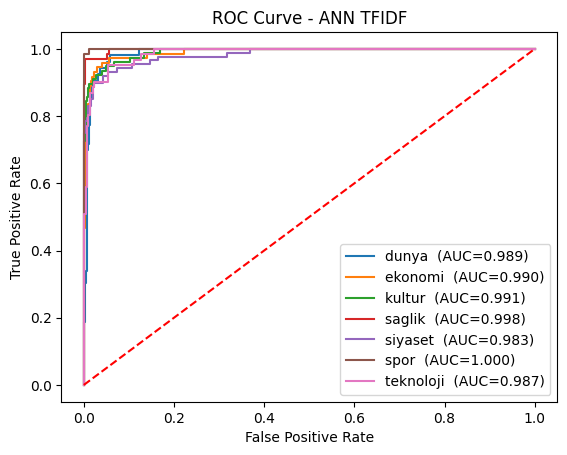

In [ ]:
# ============================
# TF-IDF ile ANN
# ============================
build_and_train_ann(
    X=tfidf_matrix,
    y=y,
    num_classes=num_classes,
    model_key="TFIDF",
    model_name="ANN TFIDF"
)




--- ANN Training with Word2Vec Features ---
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5714 - loss: 1.2002 - val_accuracy: 0.7823 - val_loss: 0.6326
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.6079 - val_accuracy: 0.7868 - val_loss: 0.5700
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.5455 - val_accuracy: 0.7982 - val_loss: 0.5585
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8324 - loss: 0.4863 - val_accuracy: 0.8027 - val_loss: 0.5329
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.4656 - val_accuracy: 0.8231 - val_loss: 0.5192
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss: 0.4365 - val_accuracy: 0.8277 - val_loss: 0.5265
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.4017 - val_accuracy: 0.8254 - val_loss: 0.5438
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.3802 - val_accuracy: 0.8345 - val_loss: 0.5331
Ac

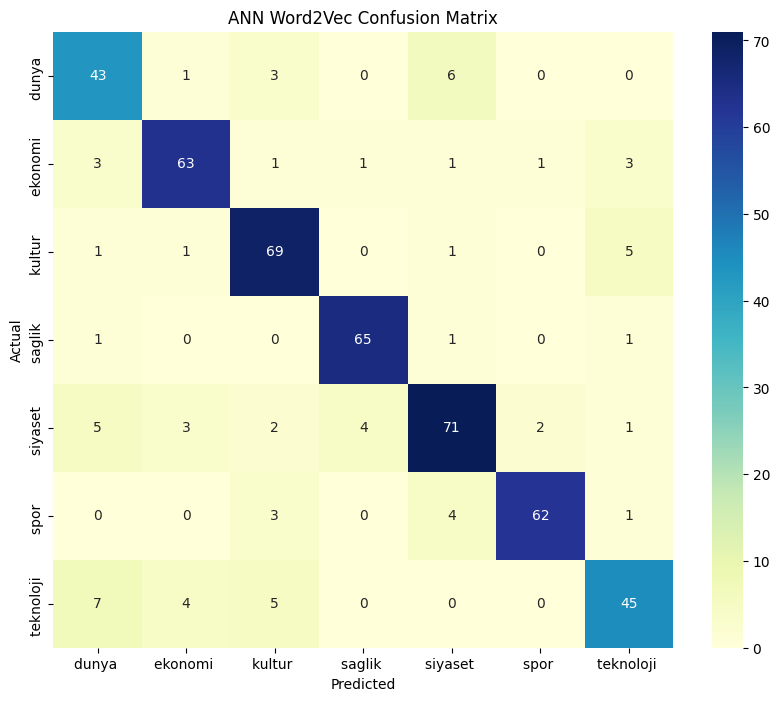

ROC AUC: 0.9830
Log Loss: 0.4189


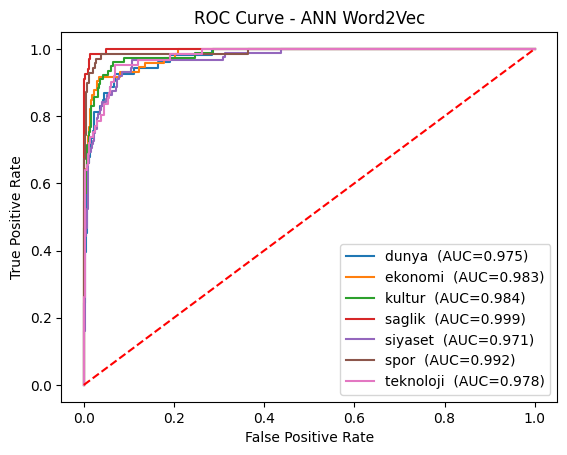

In [ ]:
# ============================
# Word2Vec ile ANN
# ============================
build_and_train_ann(
    X=word2vec_features,
    y=y,
    num_classes=num_classes,
    model_key="Word2Vec",
    model_name="ANN Word2Vec"
)



In [ ]:
print("\n--- ANN Training for All Feature Sets Completed. ---")

# Performans Özeti
print("\n--- Model Performance Summary (ANN) ---\n")
for model_name, metrics in model_performance.items():
    if model_name.startswith("ANN_"):  # Sadece ANN sonuçlarını göstermek için
        print(f"{model_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
        print()


--- ANN Training for All Feature Sets Completed. ---

--- Model Performance Summary (ANN) ---

ANN_BoW:
  Accuracy: 0.8898
  Precision: 0.8946
  Recall: 0.8898
  F1-Score: 0.8905
  ROC AUC: 0.9902
  Log Loss: 0.3259

ANN_TFIDF:
  Accuracy: 0.9082
  Precision: 0.9087
  Recall: 0.9082
  F1-Score: 0.9080
  ROC AUC: 0.9912
  Log Loss: 0.3025

ANN_Word2Vec:
  Accuracy: 0.8531
  Precision: 0.8555
  Recall: 0.8531
  F1-Score: 0.8533
  ROC AUC: 0.9830
  Log Loss: 0.4189



In [ ]:
from tensorflow.keras.layers import Input, Flatten # Add Flatten to the import statement
def build_and_train_cnn(
    X,
    y,
    label_encoder,
    num_classes,
    model_name,
    test_size=0.1,
    random_state=42,
    epochs=10,
    batch_size=64,
    patience=3,
    dropout_rate=0.5
):
    # 1) Eğitim ve test seti ayırma
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 2) Özellikleri ölçeklendirme (genellikle BOW/TF-IDF/Word2Vec ort. için yapılır)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3) Kategorik (One-hot) etiket hazırlama
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

    # 4) CNN'e uygun girdi şekli -> (num_samples, num_features, 1)
    #    (BOW/TF-IDF her sample 5000 boyutlu ise -> (N, 5000, 1))
    #    (Word2Vec ortalama vektör 100 boyutlu -> (N, 100, 1)) gibi
    X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)  # sonuna 1 boyut ekliyoruz
    X_test_cnn  = np.expand_dims(X_test_scaled,  axis=-1)

    # 5) Modeli tanımlama (oldukça basit CNN + Flatten)
    model = Sequential()
    model.add(
        Input(shape=(X_train_cnn.shape[1], 1))  # Örn. (5000,1) veya (100,1)
    )
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    # 6) Modeli derleme
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 7) EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # 8) Eğitme
    history = model.fit(
        X_train_cnn, y_train_cat,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )

    # 9) Değerlendirme
    loss, accuracy = model.evaluate(X_test_cnn, y_test_cat, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

    # 10) Tahminler
    y_pred_probs = model.predict(X_test_cnn)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # 11) Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_classes, average='weighted'
    )
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # 12) ROC AUC ve Log Loss (çok sınıflı)
    y_test_binarized = label_binarize(y_test, classes=range(num_classes))
    roc_auc = roc_auc_score(y_test_binarized, y_pred_probs, multi_class='ovr')
    logloss = log_loss(y_test_binarized, y_pred_probs)
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # 13) Confusion Matrix çizimi (opsiyonel)
    if label_encoder is not None:
        plot_confusion_matrix(y_test, y_pred_classes, label_encoder,model_name=model_name)

    # 14) ROC eğrileri (opsiyonel)
    if label_encoder is not None:
        plot_roc_curves(y_test_binarized, y_pred_probs, label_encoder,model_name=model_name)

    # 15) Performans sözlüğü
    performance_dict = {
        "Accuracy":  accuracy,
        "Precision": precision,
        "Recall":    recall,
        "F1-Score":  f1,
        "ROC AUC":   roc_auc,
        "Log Loss":  logloss
    }

    return model, performance_dict


--- CNN with BOW Features ---
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4212 - loss: 1.7072 - val_accuracy: 0.8435 - val_loss: 0.6250
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7861 - loss: 0.6456 - val_accuracy: 0.8435 - val_loss: 0.5770
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8664 - loss: 0.4123 - val_accuracy: 0.8481 - val_loss: 0.6634
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9091 - loss: 0.3180 - val_accuracy: 0.8367 - val_loss: 0.6991
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9220 - loss: 0.2412 - val_accuracy: 0.8390 - val_loss: 0.7607
Test Accuracy: 0.8673
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: 0.8714
Recall: 0.8673
F1-Score: 0.8681
ROC AUC: 0.9826
Log Loss: 0.4324


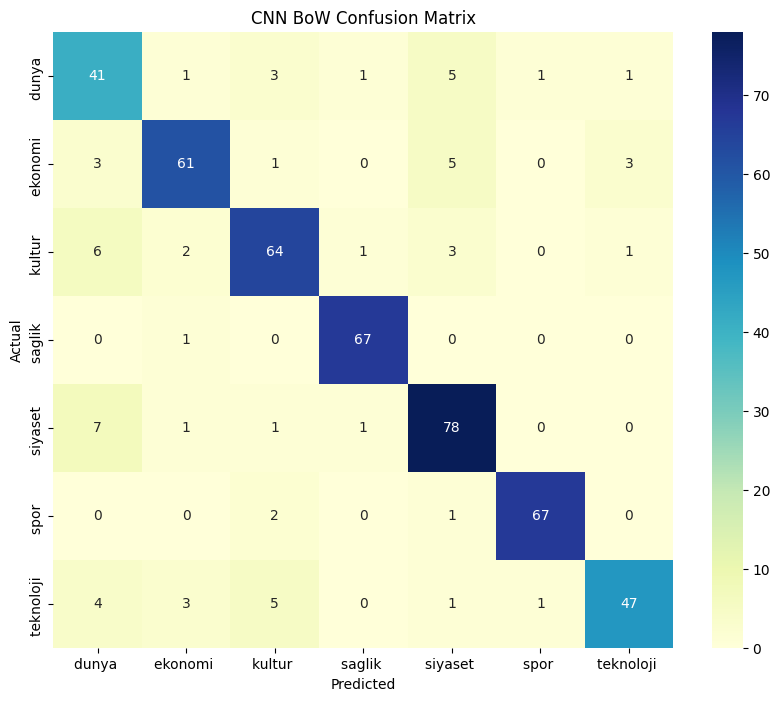

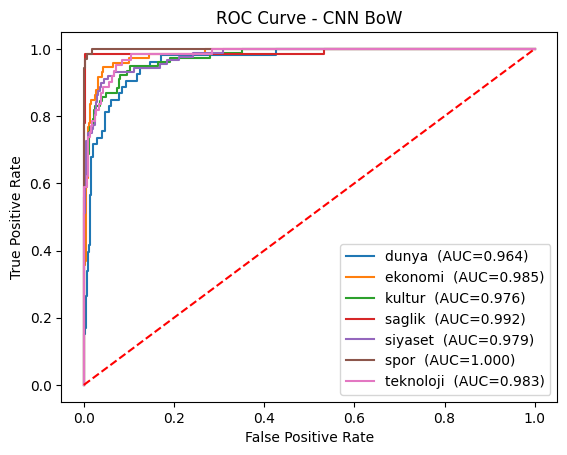

In [ ]:
print("--- CNN with BOW Features ---")
model_cnn_bow, perf_cnn_bow = build_and_train_cnn(
    X=bow_matrix,
    y=y,
    label_encoder=label_encoder,
    num_classes=num_classes,
    test_size=0.1,
    random_state=42,
    epochs=10,
    batch_size=64,
    patience=3,
    dropout_rate=0.5,
    model_name="CNN BoW"
)
model_performance["CNN_BOW"] = perf_cnn_bow



--- CNN with TF-IDF Features ---
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4414 - loss: 1.6685 - val_accuracy: 0.8549 - val_loss: 0.5680
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7776 - loss: 0.6390 - val_accuracy: 0.8662 - val_loss: 0.4678
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8567 - loss: 0.4374 - val_accuracy: 0.8481 - val_loss: 0.5609
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8975 - loss: 0.3023 - val_accuracy: 0.8617 - val_loss: 0.5908
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9230 - loss: 0.2233 - val_accuracy: 0.8639 - val_loss: 0.6443
Test Accuracy: 0.8776
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: 0.8798
Recall: 0.8776
F1-Score: 0.8782
ROC AUC: 0.9839
Log Loss: 0.4150


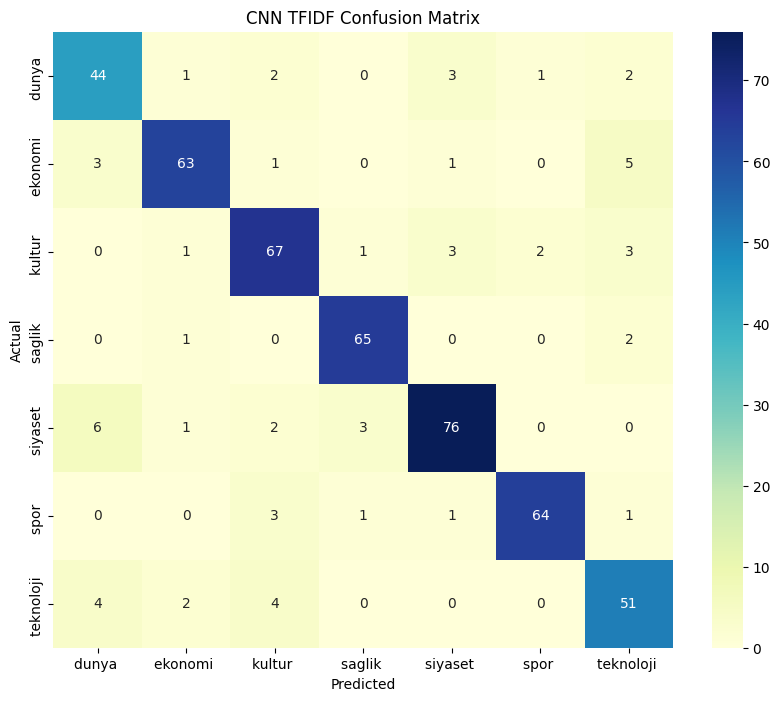

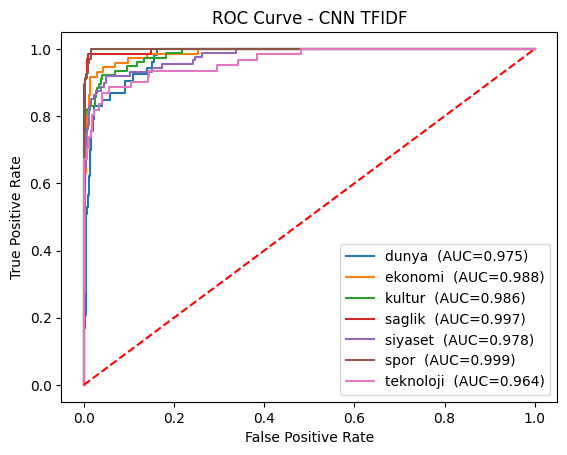

In [ ]:

print("\n--- CNN with TF-IDF Features ---")
model_cnn_tfidf, perf_cnn_tfidf = build_and_train_cnn(
    X=tfidf_matrix,
    y=y,
    label_encoder=label_encoder,
    num_classes=num_classes,
    test_size=0.1,
    random_state=42,
    epochs=10,
    batch_size=64,
    patience=3,
    dropout_rate=0.5,
    model_name="CNN TFIDF"
)
model_performance["CNN_TFIDF"] = perf_cnn_tfidf



--- CNN with Word2Vec Average Features ---
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5001 - loss: 1.3328 - val_accuracy: 0.7687 - val_loss: 0.6835
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7560 - loss: 0.7214 - val_accuracy: 0.7687 - val_loss: 0.6437
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7856 - loss: 0.6613 - val_accuracy: 0.7823 - val_loss: 0.5970
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.6302 - val_accuracy: 0.7846 - val_loss: 0.5898
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8228 - loss: 0.5668 - val_accuracy: 0.7982 - val_loss: 0.5659
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8151 - loss: 0.5524 - val_accuracy: 0.8005 - val_loss: 0.5808
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.5349 - val_accuracy: 0.8005 - val_loss: 0.5924
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - lo

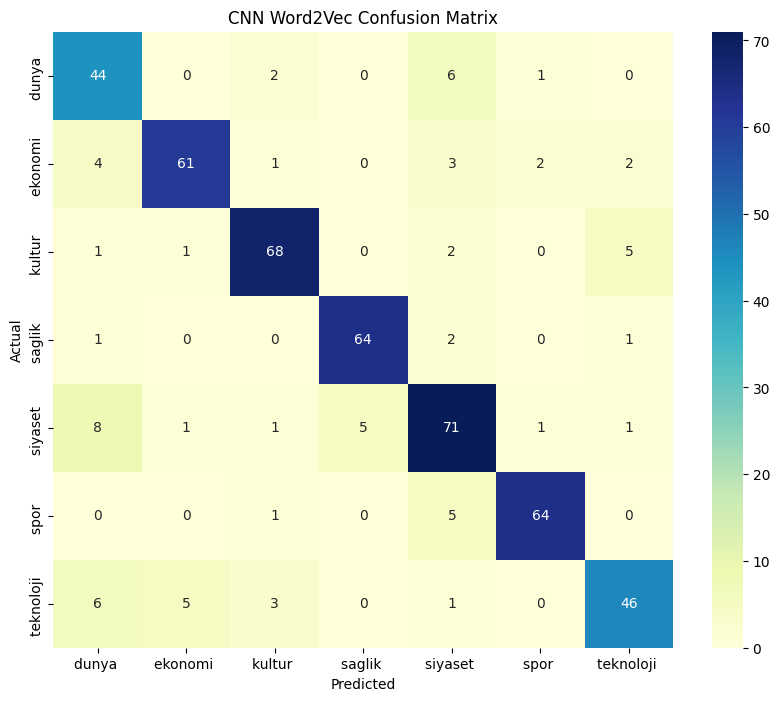

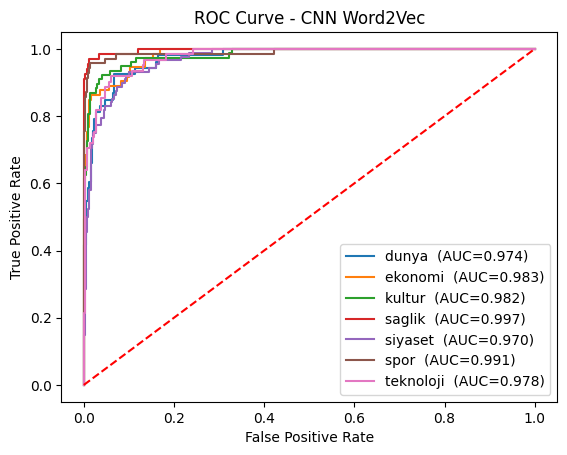

In [ ]:

print("\n--- CNN with Word2Vec Average Features ---")
model_cnn_w2v, perf_cnn_w2v = build_and_train_cnn(
    X=word2vec_features,
    y=y,
    label_encoder=label_encoder,
    num_classes=num_classes,
    test_size=0.1,
    random_state=42,
    epochs=10,
    batch_size=64,
    patience=3,
    dropout_rate=0.5,
    model_name="CNN Word2Vec"
)
model_performance["CNN_Word2Vec"] = perf_cnn_w2v



Training Samples: 4410
Evaluation Samples: 490


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.321100,0.189284
2,0.303500,0.307563
3,0.044200,0.288197


Evaluation Results: {'eval_loss': 0.2881966531276703, 'eval_runtime': 0.8873, 'eval_samples_per_second': 552.225, 'eval_steps_per_second': 34.937, 'epoch': 3.0}
Accuracy: 0.9510
Precision: 0.9516
Recall: 0.9510
F1-Score: 0.9503


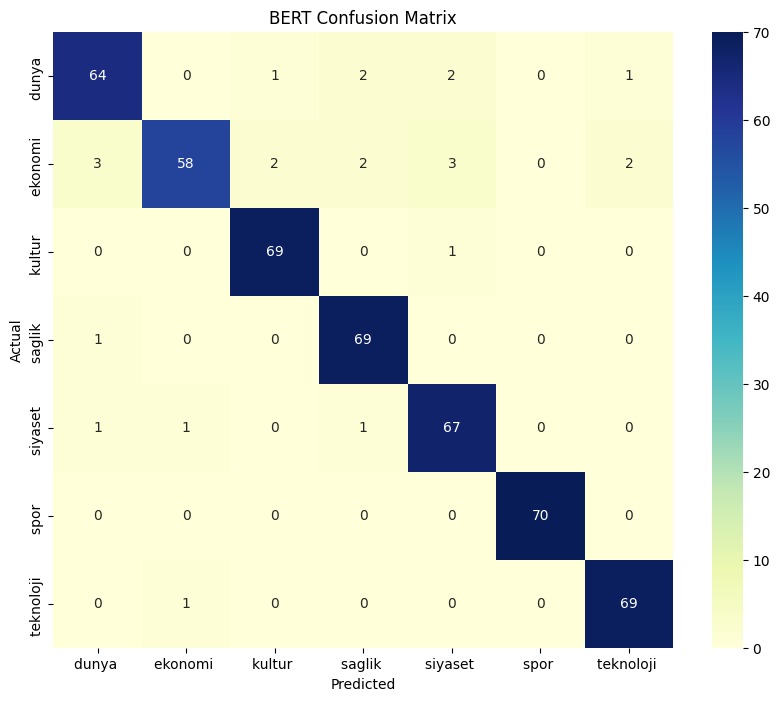

ROC AUC Score: 0.9916
Log Loss: 0.2882


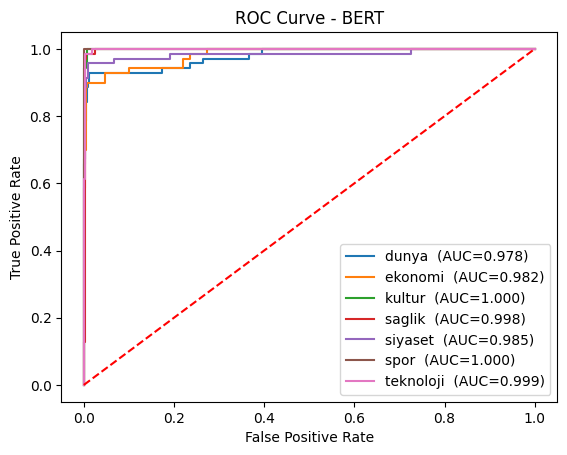


BERT Training Completed.


In [ ]:
# === Model ve Tokenizer'ı Yükle ===
model_name = "savasy/bert-turkish-text-classification"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# === Eğitim ve Değerlendirme Setlerine Ayırma ===
data = {
    'text': docs_list,  # Daha önce tanımladığınız docs_list
    'labels': y         # Daha önce tanımladığınız etiketler (y)
}
df_simple = pd.DataFrame(data)

# Eğitim ve değerlendirme setlerine ayırma
train_df, eval_df = train_test_split(df_simple, test_size=0.1, random_state=42, stratify=df_simple['labels'])
print(f"Training Samples: {len(train_df)}")
print(f"Evaluation Samples: {len(eval_df)}")

# === Tokenizasyon ===
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=128)
eval_encodings = tokenizer(list(eval_df['text']), truncation=True, padding=True, max_length=128)

# Etiketleri torch tensor formatına çevirme
train_labels = torch.tensor(train_df['labels'].values)
eval_labels = torch.tensor(eval_df['labels'].values)

# === Hugging Face Dataset Oluşturma ===
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
eval_dataset = CustomDataset(eval_encodings, eval_labels)

# === Trainer Ayarları ===
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    run_name="turkish-bert-classification"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# === Modeli Eğitmek ===
trainer.train()

# === Modeli Değerlendirmek ===
results = trainer.evaluate()
print(f"Evaluation Results: {results}")
eval_loss = results['eval_loss']

# Predict etme
predictions = trainer.predict(eval_dataset)
y_pred_logits = predictions.predictions  # Logit çıktıları
# Softmax ile olasılıklara çevirme
y_pred_probs = torch.nn.Softmax(dim=1)(torch.tensor(y_pred_logits)).numpy()
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek etiketler
y_true = eval_df['labels'].values

# === Accuracy Hesaplama ===
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# === Precision, Recall, F1-Score Hesaplama ===
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# === Confusion Matrix ===
plot_confusion_matrix(y_true, y_pred_classes, label_encoder,model_name="BERT")

# === ROC AUC Score (One-vs-Rest), Log Loss ve ROC Eğrileri ===
classes = list(range(num_classes))
y_true_binarized = label_binarize(y_true, classes=classes)

# ROC AUC Score (One-vs-Rest) ve Log Loss
roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, multi_class='ovr')
logloss = log_loss(y_true, y_pred_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

# ROC Eğrileri Hesaplama ve Çizimi (Tüm sınıflar için)
fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()

for i in range(num_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

plt.figure()
for i in range(num_classes):
    class_label = label_encoder.classes_[i]
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{class_label} (AUC={roc_auc_dict[i]:.3f})")

plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BERT')
plt.legend()
plt.show()


# === Store Performance ===
model_performance['BERT'] = {
    'Loss': eval_loss,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC': roc_auc,
    'Log Loss': logloss
}

print("\nBERT Training Completed.")


In [ ]:
# === Model ve Tokenizer'ı Yükle ===
model_name = "bert-base-multilingual-cased"  # Çok dilli BERT modelini kullanıyoruz
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# === Eğitim ve Değerlendirme Setlerine Ayırma ===
data = {
    'text': docs_list,  # Daha önce tanımladığınız docs_list
    'labels': y         # Daha önce tanımladığınız etiketler (y)
}
df_simple = pd.DataFrame(data)

# Eğitim ve değerlendirme setlerine ayırıyoruz
train_df, eval_df = train_test_split(df_simple, test_size=0.1, random_state=42, stratify=df_simple['labels'])

print(f"Training Samples: {len(train_df)}")
print(f"Evaluation Samples: {len(eval_df)}")

# === Tokenizasyon ===
# Hugging Face Tokenizer kullanarak veri kümesini token'lıyoruz
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=128)
eval_encodings = tokenizer(list(eval_df['text']), truncation=True, padding=True, max_length=128)

# Etiketlerimizi torch tensor formatına çeviriyoruz
train_labels = torch.tensor(train_df['labels'].values)
eval_labels = torch.tensor(eval_df['labels'].values)

# === Hugging Face Dataset Oluşturma ===
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Datasetleri oluşturuyoruz
train_dataset = CustomDataset(train_encodings, train_labels)
eval_dataset = CustomDataset(eval_encodings, eval_labels)

# === Trainer Ayarları ===
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,  # Eğitimi 3 epoch yapıyoruz
    per_device_train_batch_size=16,  # Eğitim batch boyutu
    per_device_eval_batch_size=16,   # Değerlendirme batch boyutu
    warmup_steps=500,  # Eğitimde öğrenme hızını 500 adımda artırıyoruz
    weight_decay=0.01,  # Ağırlık azaltma oranı
    logging_dir='./logs',  # Log dosyalarının kaydedileceği dizin
    logging_steps=10,  # Loglama sıklığı
    evaluation_strategy="epoch",  # Her epoch sonunda değerlendirme yapılacak
    save_strategy="epoch",  # Her epoch sonunda model kaydedilecek
    run_name="turkish-bert-classification"  # Çalışma adı
)

# Trainer'ı oluşturuyoruz
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# === Modeli Eğitmek ===
trainer.train()

# === Modeli Değerlendirmek ===
results = trainer.evaluate()

# Değerlendirme sonuçlarını yazdırıyoruz
print(f"Evaluation Results: {results}")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Samples: 4410
Evaluation Samples: 490


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.540700,0.507284
2,0.584200,0.688248
3,0.181700,0.356218


Evaluation Results: {'eval_loss': 0.356217622756958, 'eval_runtime': 0.8924, 'eval_samples_per_second': 549.069, 'eval_steps_per_second': 34.737, 'epoch': 3.0}


Evaluation Results: {'eval_loss': 0.356217622756958, 'eval_runtime': 0.8584, 'eval_samples_per_second': 570.797, 'eval_steps_per_second': 36.112, 'epoch': 3.0}
Accuracy: 0.9061
Precision: 0.9073
Recall: 0.9061
F1-Score: 0.9058


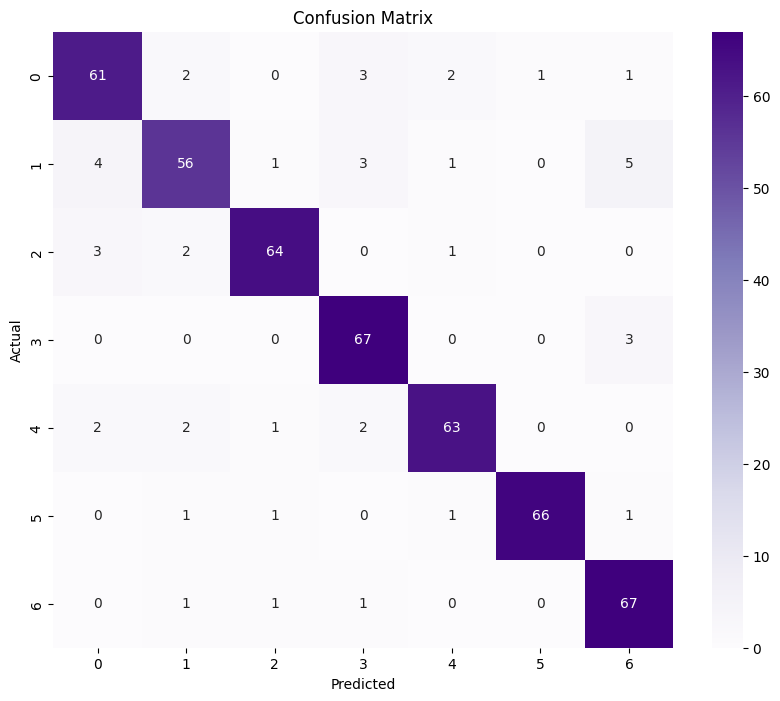

ROC AUC Score: 0.9860

BERT Training Completed.


In [ ]:


# === Modeli Değerlendirmek ===
results = trainer.evaluate()

# Değerlendirme Sonuçları (eval_loss)
print(f"Evaluation Results: {results}")
eval_loss = results['eval_loss']

# Predict the labels on eval set
predictions = trainer.predict(eval_dataset)
y_pred_classes = np.argmax(predictions.predictions, axis=1)

# Gerçek etiketler
y_true = eval_df['labels'].values

# === Accuracy Hesaplama ===
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# === Precision, Recall, F1-Score Hesaplama ===
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# === Confusion Matrix ===
plot_confusion_matrix(y_true, y_pred_classes, label_encoder,model_name="BERT")

# === ROC AUC Score (One-vs-Rest), Log Loss ve ROC Eğrileri ===
classes = list(range(num_classes))
y_true_binarized = label_binarize(y_true, classes=classes)

# ROC AUC Score (One-vs-Rest) ve Log Loss
roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, multi_class='ovr')
logloss = log_loss(y_true, y_pred_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

# ROC Eğrileri Hesaplama ve Çizimi (Tüm sınıflar için)
fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()

for i in range(num_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

plt.figure()
for i in range(num_classes):
    class_label = label_encoder.classes_[i]
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{class_label} (AUC={roc_auc_dict[i]:.3f})")

plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BERT')
plt.legend()
plt.show()
# === Store Performance ===
model_performance['BERT'] = {
    'Loss': eval_loss,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC': roc_auc
}

print("\nBERT Training Completed.")


In [ ]:
# 4) Sonuçları yazdırma
print("\n--- Model Performance Summary ---")
for model_key, metrics in model_performance.items():
    print(f"\nModel: {model_key}")
    for m_name, m_value in metrics.items():
        print(f"{m_name}: {m_value:.4f}")


--- Model Performance Summary ---

Model: ANN_BoW
Accuracy: 0.8898
Precision: 0.8946
Recall: 0.8898
F1-Score: 0.8905
ROC AUC: 0.9902
Log Loss: 0.3259

Model: ANN_TFIDF
Accuracy: 0.9082
Precision: 0.9087
Recall: 0.9082
F1-Score: 0.9080
ROC AUC: 0.9912
Log Loss: 0.3025

Model: ANN_Word2Vec
Accuracy: 0.8531
Precision: 0.8555
Recall: 0.8531
F1-Score: 0.8533
ROC AUC: 0.9830
Log Loss: 0.4189

Model: CNN_BOW
Accuracy: 0.8673
Precision: 0.8714
Recall: 0.8673
F1-Score: 0.8681
ROC AUC: 0.9826
Log Loss: 0.4324

Model: CNN_TFIDF
Accuracy: 0.8776
Precision: 0.8798
Recall: 0.8776
F1-Score: 0.8782
ROC AUC: 0.9839
Log Loss: 0.4150

Model: CNN_Word2Vec
Accuracy: 0.8531
Precision: 0.8576
Recall: 0.8531
F1-Score: 0.8541
ROC AUC: 0.9824
Log Loss: 0.4306

Model: BERT
Loss: 0.2882
Accuracy: 0.9510
Precision: 0.9516
Recall: 0.9510
F1-Score: 0.9503
ROC AUC: 0.9916
Log Loss: 0.2882


In [ ]:
additional_rows = []

# COMPLEX NEURAL NETWORK
features = ["Word2Vec", "TFIDF", "BOW"]

for feature in features:
    key = f'CNN_{feature}'
    cnn_perf = model_performance.get(key, {})
    row_cnn = {
        "Model+Feature": f"CNN ({feature})",
        "Accuracy": cnn_perf.get("Accuracy", np.nan),
        "Precision": cnn_perf.get("Precision", np.nan),
        "Recall": cnn_perf.get("Recall", np.nan),
        "F1-Score": cnn_perf.get("F1-Score", np.nan),
        "ROC_AUC": cnn_perf.get("ROC AUC", np.nan),
        "Log_Loss": cnn_perf.get("Log Loss", np.nan)
    }
    additional_rows.append(row_cnn)


# BERT
bert_perf = model_performance['BERT']
# "Loss" metrik ismini "Log_Loss" olarak güncellemek istersek:
log_loss_val = bert_perf.get("Loss", np.nan)
row_bert = {
    "Model+Feature": "BERT",
    "Accuracy": bert_perf.get("Accuracy", np.nan),
    "Precision": bert_perf.get("Precision", np.nan),
    "Recall": bert_perf.get("Recall", np.nan),
    "F1-Score": bert_perf.get("F1-Score", np.nan),
    "ROC_AUC": bert_perf.get("ROC AUC", np.nan),
    "Log_Loss": bert_perf.get("Loss", np.nan)
}
additional_rows.append(row_bert)

# Ek modellerin satırlarını da df_results_wide'a ekleyelim
df_additional = pd.DataFrame(additional_rows)
df_results_wide = pd.concat([df_results_wide, df_additional], ignore_index=True)


In [ ]:
# Yeni satırları tutmak için liste oluşturuyoruz
additional_rows = []

# İncelenen özellik setleri
features = ["Word2Vec", "TFIDF", "BoW"]

for feature in features:
    key = f'ANN_{feature}'
    ann_perf = model_performance.get(key, {})
    row_ann = {
        "Model+Feature": f"ANN ({feature})",
        "Accuracy": ann_perf.get("Accuracy", np.nan),
        "Precision": ann_perf.get("Precision", np.nan),
        "Recall": ann_perf.get("Recall", np.nan),
        "F1-Score": ann_perf.get("F1-Score", np.nan),
        "ROC_AUC": ann_perf.get("ROC AUC", np.nan),
        "Log_Loss": ann_perf.get("Log Loss", np.nan)
    }
    additional_rows.append(row_ann)

# Yeni satırları DataFrame'e dönüştürme
df_ann = pd.DataFrame(additional_rows)

# Mevcut sonuçlara ekleme
df_results_wide = pd.concat([df_results_wide, df_ann], ignore_index=True)

print("Güncellenmiş sonuçlar (geniş form):")
display(df_results_wide)

Güncellenmiş sonuçlar (geniş form):


,Model+Feature,Accuracy,Precision,Recall,F1-Score,ROC_AUC,Log_Loss
0,RF + Word2Vec,0.834694,0.838874,0.834694,0.834308,0.977750,0.578204
1,RF + TF-IDF,0.906122,0.906671,0.906122,0.905370,0.989332,0.565562
2,RF + BoW,0.885714,0.888377,0.885714,0.884712,0.987612,0.568242
3,XGBoost + BoW,0.900000,0.900651,0.900000,0.898609,0.991210,0.282583
4,XGBoost + TF-IDF,0.906122,0.905638,0.906122,0.904515,0.990496,0.296602
5,XGBoost + Word2Vec,0.857143,0.860812,0.857143,0.857346,0.982221,0.495904
6,LightGBM + BoW,0.928571,0.927968,0.928571,0.927801,0.992405,0.280274
7,LightGBM + TF-IDF,0.922449,0.921853,0.922449,0.921771,0.992488,0.283292
8,LightGBM + Word2Vec,0.853061,0.856793,0.853061,0.853565,0.983081,0.537868
9,SVM + BoW,0.885714,0.887014,0.885714,0.885549,0.982964,0.402943


In [ ]:
df_long = df_results_wide.melt(
    id_vars=['Model+Feature'],
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC', 'Log_Loss'],
    var_name='Metric',
    value_name='Value'
)

display(df_long.head(12))  # İlk 12 satıra göz atalım

,Model+Feature,Metric,Value
0,RF + Word2Vec,Accuracy,0.834694
1,RF + TF-IDF,Accuracy,0.906122
2,RF + BoW,Accuracy,0.885714
3,XGBoost + BoW,Accuracy,0.900000
4,XGBoost + TF-IDF,Accuracy,0.906122
5,XGBoost + Word2Vec,Accuracy,0.857143
6,LightGBM + BoW,Accuracy,0.928571
7,LightGBM + TF-IDF,Accuracy,0.922449
8,LightGBM + Word2Vec,Accuracy,0.853061
9,SVM + BoW,Accuracy,0.885714


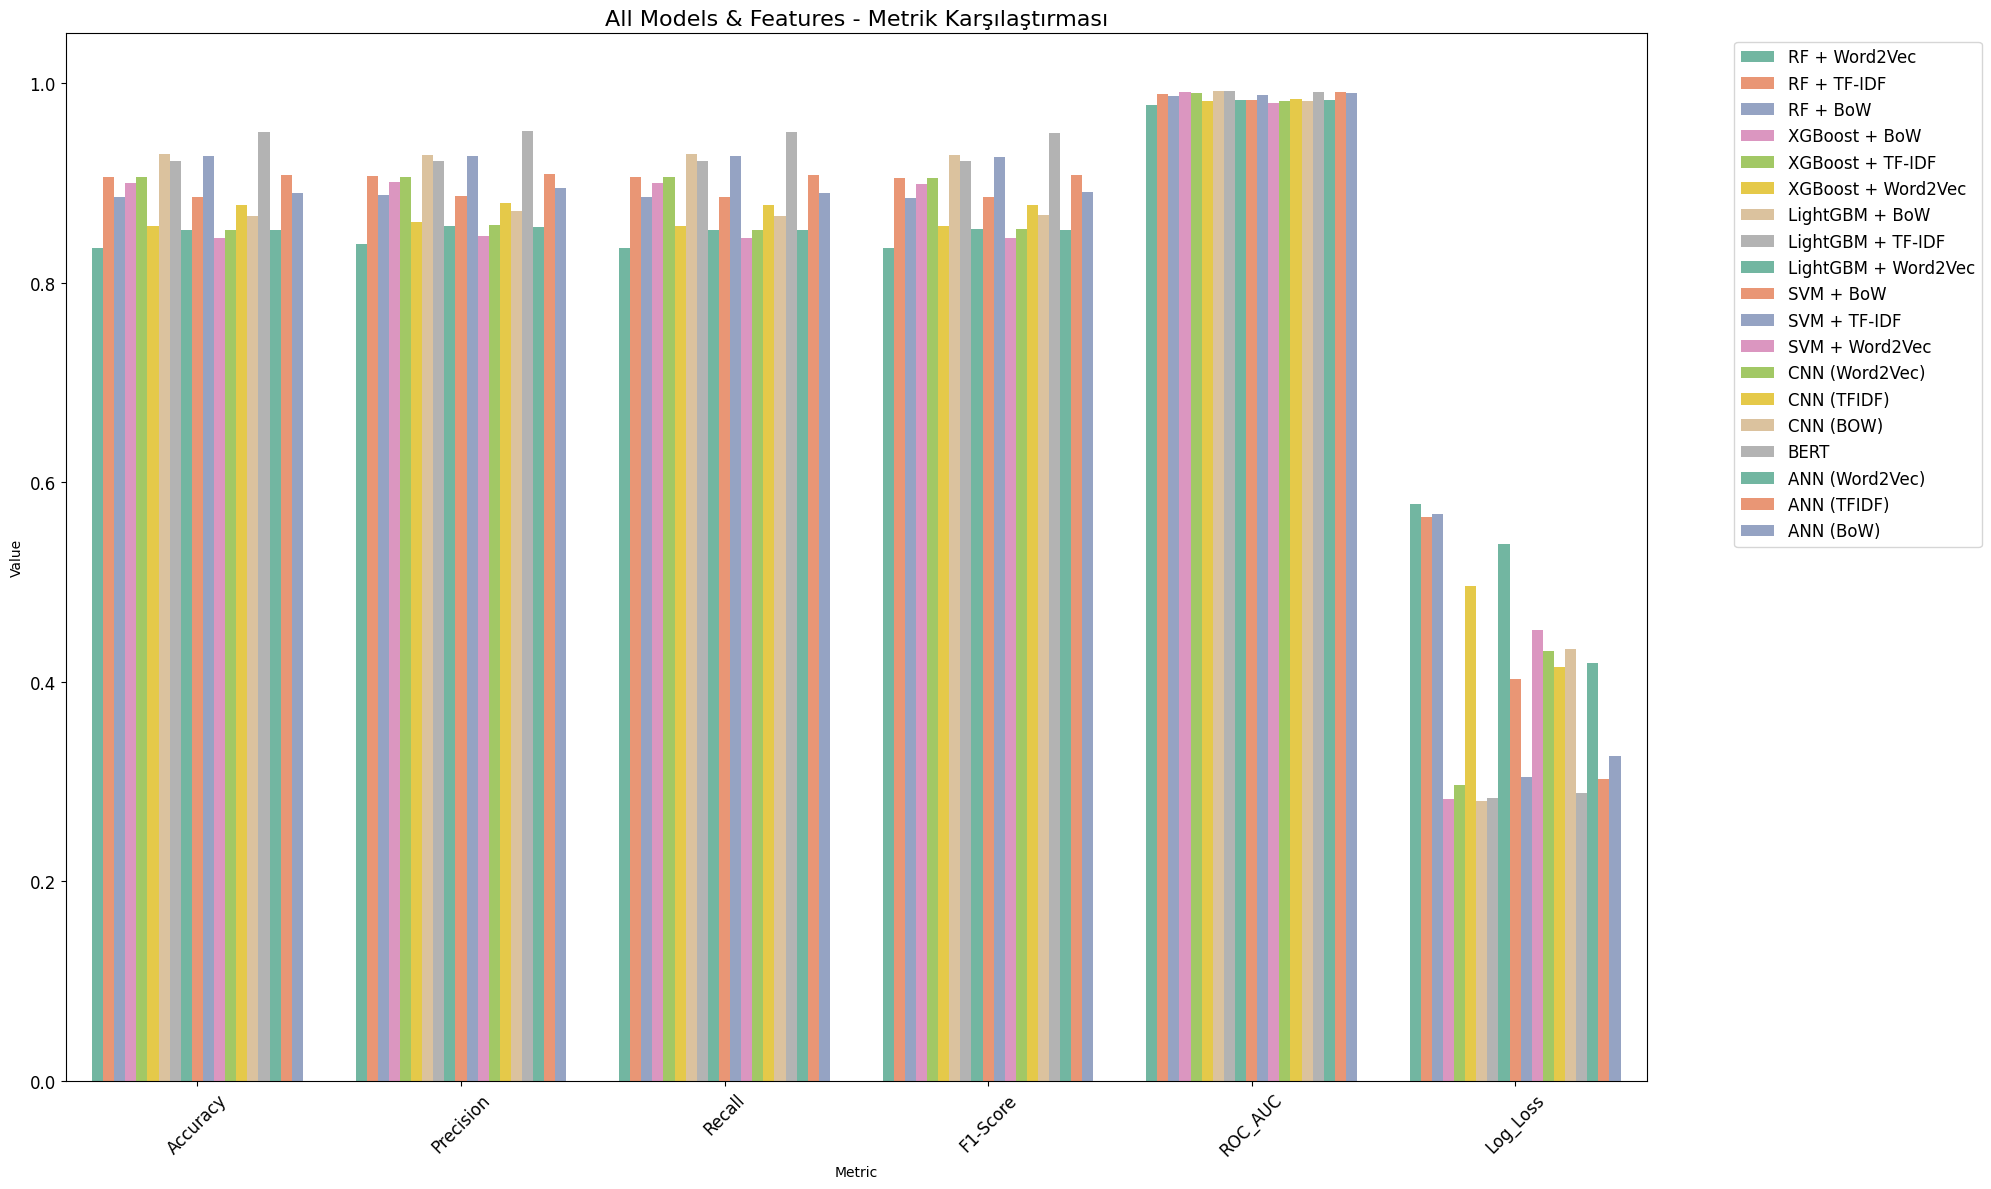

In [ ]:
unique_categories = df_long['Model+Feature'].nunique()
palette = sns.color_palette("Set2", n_colors=unique_categories)

plt.figure(figsize=(20,12))
sns.barplot(data=df_long,
            x='Metric',
            y='Value',
            hue='Model+Feature',
            palette=palette)  # Belirlenen paleti kullanalım

plt.title("All Models & Features - Metrik Karşılaştırması", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.05)

# Efsaneyi grafiğin yanına yerleştirme
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()